## Initialization

In [113]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
pd.set_option('display.width', 300)

In [114]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/Sales Project/'
sales = pd.read_csv(root_path + 'Sales Dataset.csv', encoding='latin1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [115]:
print(sales.head())

  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55   17,850.00  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39   17,850.00  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75   17,850.00  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39   17,850.00  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39   17,850.00  United Kingdom


In [116]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,"541,909.00",9.55,218.08,"-80,995.00",1.00,3.00,10.00,"80,995.00"
UnitPrice,"541,909.00",4.61,96.76,"-11,062.06",1.25,2.08,4.13,"38,970.00"
CustomerID,"406,829.00","15,287.69","1,713.60","12,346.00","13,953.00","15,152.00","16,791.00","18,287.00"


In [117]:
sales.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


### Handling Missing Values

In [118]:
missing_values = pd.DataFrame(sales.dtypes).T.rename(index={0:'Data Type'})
missing_ = pd.DataFrame(sales.isnull().sum()).T.rename(index={0:'Missing Values'})
missing_pct = pd.DataFrame(sales.isnull().sum()/sales.shape[0]*100).T.rename(index={0:'Missing Values (%)'})
missing_values = pd.concat([missing_values, missing_, missing_pct])
missing_values

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Data Type,object,object,object,int64,object,float64,float64,object
Missing Values,0,0,1454,0,0,0,135080,0
Missing Values (%),0.00,0.00,0.27,0.00,0.00,0.00,24.93,0.00


There are around 25% of invoices that are not assign to any customer. There is no information to fill in this values and it is useless to include these records to segment customers, thus these datapoints will be removed.

In [119]:
sales.dropna(axis=0,subset=['CustomerID'], inplace=True)
missing_values = pd.DataFrame(sales.dtypes).T.rename(index={0:'Data Type'})
missing_ = pd.DataFrame(sales.isnull().sum()).T.rename(index={0:'Missing Values'})
missing_pct = pd.DataFrame(sales.isnull().sum()/sales.shape[0]*100).T.rename(index={0:'Missing Values (%)'})
missing_values = pd.concat([missing_values, missing_, missing_pct])
missing_values

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Data Type,object,object,object,int64,object,float64,float64,object
Missing Values,0,0,0,0,0,0,0,0
Missing Values (%),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Checking duplicate values

In [120]:
duplicate_rows = sales[sales.duplicated(keep=False)]
print(sales.shape[0])
print(duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID']).head(10))

406829
    InvoiceNo StockCode                       Description  Quantity      InvoiceDate  UnitPrice  CustomerID         Country
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1  12/1/2010 11:45       1.25   17,908.00  United Kingdom
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1  12/1/2010 11:45       1.25   17,908.00  United Kingdom
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1  12/1/2010 11:45       4.95   17,908.00  United Kingdom
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1  12/1/2010 11:45       4.95   17,908.00  United Kingdom
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1  12/1/2010 11:45       2.10   17,908.00  United Kingdom
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1  12/1/2010 11:45       2.10   17,908.00  United Kingdom
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1  12/1/2010 11:45       2.95   17,908.00  United Kingdom
5

Duplicate rows are eliminated before continuing with the analysis

In [121]:
sales.drop_duplicates(inplace=True)
sales.shape[0]

401604

### Canceled Transactions

In [122]:
cancelled_transactions = sales[sales['InvoiceNo'].astype(str).str.contains('C')].head()
cancelled_transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,"14,527.00",United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,"15,311.00",United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,"17,548.00",United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,"17,548.00",United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,"17,548.00",United Kingdom


It seems that cancelled transactions have negative quantities, let's corroborate that.

In [123]:
cancelled_transactions.describe().drop(columns='CustomerID').T

,count,mean,std,min,25%,50%,75%,max
Quantity,5.00,-12.40,11.50,-24.00,-24.00,-12.00,-1.00,-1.00
UnitPrice,5.00,6.88,11.67,0.29,0.29,1.65,4.65,27.50


As observed, the minimum and maximum values are negative, indicating that all cancelled transactions are negative—likely due to item returns. Since the goal of this project is to segment customers based on purchasing behavior, it is important to investigate the reasons behind transaction cancellations, but only if they occur at a significant rate. Therefore, the percentage of cancelled transactions will be calculated to determine whether this phenomenon is substantial enough to warrant further analysis.

In [124]:
# Creating a column to identify cancelled transactions
sales['TransactionStatus'] = np.where(sales['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Purchased')
# Calculating percentage of cancelled transactions
total_invoices = sales['InvoiceNo'].nunique()
cancelled_invoices = sales[sales['TransactionStatus'] == 'Cancelled']['InvoiceNo'].nunique()
pct_cancelled_transactions = (cancelled_invoices / total_invoices) * 100
print(f'% Cancelled Transactions: {pct_cancelled_transactions}')
# Calculating percentage of cancelled products
cancelled_items = sales[sales['TransactionStatus'] == 'Cancelled']
pct_cancelled_items = (cancelled_items.shape[0] / sales.shape[0]) * 100
print(f'% Cancelled Items: {pct_cancelled_items}')

% Cancelled Transactions: 16.466876971608833
% Cancelled Items: 2.209141343213713


From these results, we can infer that cancelled transactions are significant, reaching up to 16%, which is a substantial figure in the context of sales. Moreover, cancelled transactions tend to include fewer items per basket compared to non-cancelled ones, which explains the gap between the percentage of cancelled transactions and the percentage of cancelled items. Therefore, this feature will be taken into account in the customer segmentation analysis.However, cancelled entries without its counterpart will be removed.

In [125]:
sales.sort_values(by=['CustomerID','StockCode']).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionStatus
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,"12,346.00",United Kingdom,Purchased
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,"12,346.00",United Kingdom,Cancelled
148306,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,4/7/2011 10:43,0.25,"12,347.00",Iceland,Purchased
220583,556201,17021,NAMASTE SWAGAT INCENSE,36,6/9/2011 13:01,0.30,"12,347.00",Iceland,Purchased
148289,549222,20665,RED RETROSPOT PURSE,6,4/7/2011 10:43,2.95,"12,347.00",Iceland,Purchased


In [126]:
# Getting cancelled transactions that have their counterpart
df_cancelled = sales[sales['Quantity']<0].copy()
df_purchased = sales[sales['Quantity']>0].copy()

df_cancelled['AbsQuantity'] = df_cancelled['Quantity'].abs()
df_purchased['AbsQuantity'] = df_purchased['Quantity'].abs()

df_cancelled_1 = df_cancelled.merge(df_purchased, how='inner', on=['CustomerID','StockCode','Description','AbsQuantity'], suffixes=('_cancelled', '_purchased'))
df_cancelled_1 = df_cancelled_1[df_cancelled_1['InvoiceDate_cancelled']>df_cancelled_1['InvoiceDate_purchased']]

df_cancelled_1['TimeDiff'] = (pd.to_datetime(df_cancelled_1['InvoiceDate_cancelled']) - pd.to_datetime(df_cancelled_1['InvoiceDate_purchased'])).dt.total_seconds().div(86400)

# Picking the closest transaction to each cancellation
df_cancelled_grouped = df_cancelled_1.sort_values('TimeDiff').groupby(['InvoiceNo_cancelled', 'StockCode', 'Description', 'CustomerID']).first().reset_index()

df_cancelled_grouped = df_cancelled_grouped[['InvoiceNo_cancelled','StockCode','Description','Quantity_cancelled','CustomerID']]
df_cancelled_grouped.columns = ['InvoiceNo','StockCode','Description','Quantity','CustomerID']

In [127]:
# Filtering cancelled transactions that has a counterpart
sales = sales.merge(
    df_cancelled_grouped,
    on=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'CustomerID'],
    how='left',
    indicator=True
)

def column_classification(row):
    if row['TransactionStatus'] == 'Purchased':
        return 'Purchased'
    elif row['_merge'] == 'both':
        return 'Cancelled with counterpart'
    else:
        return 'Other cancelled'

sales['StatusCode'] = sales.apply(column_classification, axis=1)
sales = sales[sales['StatusCode'] != 'Other cancelled']

### Analyzing StockCodes

In [128]:
top_10_stock_codes = sales['StockCode'].value_counts(normalize=True).head(10) * 100
top_10_stock_codes

,proportion
StockCode,
85123A,0.52
22423,0.44
85099B,0.41
47566,0.35
84879,0.35
20725,0.33
22720,0.29
POST,0.28
23203,0.28


The structure of stock codes appears to follow a pattern of either five digits or five digits followed by a letter. This may indicate that regular customer transactions are associated with purely numeric stock codes with a minimum length of five. Therefore, it is worth investigating whether these alternative stock codes represent a significant portion of the dataset.

In [129]:
stock_codes = sales['StockCode'].unique()
numeric_char_freq = pd.Series(stock_codes).astype(str).str.len().value_counts()
numeric_char_freq

,count
5,2785
6,873
4,2
7,1
2,1
1,1
12,1
3,1


In [130]:
stock_codes_name = [i for i in stock_codes if len(str(i)) in (1, 2, 3, 4, 7, 12)]
stock_codes_name

['POST', '15056BL', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']

Since the number of distinct stock codes with different formats is very small and the goal of the project is to analyze customer behavior for segmentation purposes, those stock codes will be removed.

In [131]:
sales = sales[~sales['StockCode'].isin(stock_codes_name)]

The 'Description' column will not be considered, as the segmentation will focus on RFM and other related behavioral variables.

### Unit Price Analysis

In [132]:
sales[sales['UnitPrice']==0].shape[0]

33

Products with a unit price of zero are likely data entry errors, and their quantity is not significant. Therefore, to avoid introducing noise into the analysis, they will be removed.

In [133]:
sales = sales[sales['UnitPrice']>0]

## FEATURE ENGINEERING

### RFM features

RFM features will be engineered from the dataset, as it contains rich transactional information that can provide valuable insights for customer segmentation.

In [134]:
# PURCHASED RECORDS ONLY
purchased = sales[sales['TransactionStatus']=='Purchased'].copy()
purchased['InvoiceDate'] = pd.to_datetime(purchased['InvoiceDate']).dt.date

#### Recency

Recency feature will be calculated as the** number of days after the last visit**.


##### Days Since Last Purchase

In [135]:
# =========== DAYS SINCE LAST PURCHASE ============
# Converting InvoiceDate to DateTime
#purchased['InvoiceDate'] = pd.to_datetime(purchased['InvoiceDate'])
#purchased['InvoiceDay'] = purchased['InvoiceDate'].dt.date
# Calculating Recency
df_customer = purchased.groupby('CustomerID')['InvoiceDate'].max().reset_index()
max_date = pd.to_datetime(purchased['InvoiceDate'].max())

df_customer['InvoiceDay'] = pd.to_datetime(df_customer['InvoiceDate'])
df_customer['DaySinceLastPurchase'] = (max_date - df_customer['InvoiceDay']).dt.days
df_customer.drop(columns=['InvoiceDay','InvoiceDate'], inplace=True)
df_customer.head()

,CustomerID,DaySinceLastPurchase
0,"12,346.00",325
1,"12,347.00",2
2,"12,348.00",75
3,"12,349.00",18
4,"12,350.00",310


#### Frequency

For frequency, four features will be considered: **the total number of orders (baskets)**, the **time between a customer’s first and last purchase (Span Purchase)**, **average basket size** and **days between purchases**. These metrics provide insight into customer engagement over time, distinguishing between occasional buyers and consistently active customers. **purchase span** reflects purchasing longevity, while **average basket size** and **baskets** captures how many items customers buy per visit and how many times they have bought. Finally, **days between purchases** will give insights on how frequently customers buy.

##### Baskets

All transactions during the same day will be considered as one.

In [136]:
# =========== BASKETS ============
baskets = purchased.groupby('CustomerID')['InvoiceDate'].nunique().reset_index(name='Baskets')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, baskets, on='CustomerID')

In [137]:
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets
0,"12,346.00",325,1
1,"12,347.00",2,7
2,"12,348.00",75,4
3,"12,349.00",18,1
4,"12,350.00",310,1


##### Purchase Span

In [138]:
# =========== PURCHASE SPAN ============
purchase_span = purchased.groupby('CustomerID').agg(
    PurchaseSpanDays = ('InvoiceDate', lambda x: (x.max() - x.min()).days)
).reset_index()
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, purchase_span, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays
0,"12,346.00",325,1,0
1,"12,347.00",2,7,365
2,"12,348.00",75,4,283
3,"12,349.00",18,1,0
4,"12,350.00",310,1,0


##### Average Basket Size

In [139]:
# =========== AVERAGE BASKET SIZE ============
basket_size = purchased.groupby(['CustomerID','InvoiceDate'])['Quantity'].sum().reset_index(name='BasketSize')
basket_size.sort_values(by='BasketSize', ascending=False).head()

,CustomerID,InvoiceDate,BasketSize
11573,"16,446.00",2011-12-09,80995
0,"12,346.00",2011-01-18,74215
14292,"17,450.00",2011-09-20,25930
6716,"14,646.00",2011-10-20,18140
155,"12,415.00",2011-06-15,15241


In [140]:
purchased[(purchased.CustomerID==16446) & (purchased.InvoiceNo=='581483')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionStatus,_merge,StatusCode
401131,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,"16,446.00",United Kingdom,Purchased,left_only,Purchased


As we can see there are some outliers. For instance, this customer bought 80,995 units of paper craft. Outliers will be handled after Feature engineering.

In [141]:
avg_basket = basket_size.groupby('CustomerID')['BasketSize'].mean().reset_index(name='AvgBasketSize')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, avg_basket, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize
0,"12,346.00",325,1,0,"74,215.00"
1,"12,347.00",2,7,365,351.14
2,"12,348.00",75,4,283,583.00
3,"12,349.00",18,1,0,630.00
4,"12,350.00",310,1,0,196.00


##### Days Between Purchases

In [142]:
# =========== DAYS BETWEEN PURCHASES ============
purchase_frequency = purchased[['CustomerID','InvoiceDate']] \
                    .drop_duplicates() \
                    .sort_values(by=['CustomerID','InvoiceDate'])
# Calculating difference in days
purchase_frequency['InvoiceDate'] = pd.to_datetime(purchase_frequency['InvoiceDate'])
purchase_frequency['DaysBetPurch'] = purchase_frequency.groupby(['CustomerID'])['InvoiceDate'] \
                    .diff() \
                    .dt.days
# Replacing NaN values for 0 for those customers that bought once only
purchase_frequency.loc[
    purchase_frequency['CustomerID'].isin(df_customer[df_customer['Baskets']==1]['CustomerID']),
    'DaysBetPurch'
] = 0
# Eliminating null values
purchase_frequency.dropna(subset='DaysBetPurch', inplace=True)
AvgDaysBetPurch = purchase_frequency.groupby('CustomerID')['DaysBetPurch'].mean().reset_index(name='AvgDaysBetPurch')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, AvgDaysBetPurch, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch
0,"12,346.00",325,1,0,"74,215.00",0.00
1,"12,347.00",2,7,365,351.14,60.83
2,"12,348.00",75,4,283,583.00,94.33
3,"12,349.00",18,1,0,630.00,0.00
4,"12,350.00",310,1,0,196.00,0.00


#### Monetary

For monetary, **Total Spend** and **Average Spend** will be considered to analyse the spending behaviour.

##### Total Spend

In [143]:
total_spend = (purchased['Quantity'] * purchased['UnitPrice']).groupby(purchased['CustomerID']).sum().reset_index(name='TotalSpend')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, total_spend, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60"
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00"
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24"
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55"
4,"12,350.00",310,1,0,196.00,0.00,294.40


##### Average Spend

In [144]:
avg_spend = (purchased['Quantity'] * purchased['UnitPrice']).groupby(purchased['CustomerID']).mean().reset_index(name='AvgSpend')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, avg_spend, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60","77,183.60"
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00",23.68
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24",53.23
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55",20.24
4,"12,350.00",310,1,0,196.00,0.00,294.40,18.40


### Product Diversity

**Product diversity** will be measured as the number of unique products purchased by a customer, to capture their preferences more accurately.

In [145]:
product_diversity = purchased.groupby('CustomerID')['StockCode'].nunique().reset_index(name='ProductDiversity')
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, product_diversity, on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60","77,183.60",1
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00",23.68,103
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24",53.23,21
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55",20.24,72
4,"12,350.00",310,1,0,196.00,0.00,294.40,18.40,16


### Purchase Country

This feature will identify the country where the customer bought.

In [146]:
print(purchased['Country'].value_counts(normalize=True).head())
print(purchased['Country'].value_counts(normalize=True).tail())

Country
United Kingdom   0.89
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.01
Name: proportion, dtype: float64
Country
Lithuania        0.00
Brazil           0.00
Czech Republic   0.00
Bahrain          0.00
Saudi Arabia     0.00
Name: proportion, dtype: float64


The vast majority of purchases were made in the UK, thus it is crucial to segment customers based on whether the purchase was made in the UK or elsewhere.

In [147]:
purchased.groupby(['CustomerID'])['Country'].nunique().reset_index(name='CountryCount').sort_values(by='CountryCount', ascending=False).head()

,CustomerID,CountryCount
90,"12,455.00",2
92,"12,457.00",2
56,"12,417.00",2
60,"12,422.00",2
67,"12,429.00",2


In [148]:
purchased.groupby('CustomerID')['Country'].nunique().reset_index(name='CountryCount').query('CountryCount > 1').head()

,CustomerID,CountryCount
20,"12,370.00",2
38,"12,394.00",2
56,"12,417.00",2
60,"12,422.00",2
67,"12,429.00",2


In [149]:
purchased[purchased['CustomerID']==12370][['CustomerID','Country','InvoiceNo','InvoiceDate']].drop_duplicates()

,CustomerID,Country,InvoiceNo,InvoiceDate
19262,"12,370.00",Cyprus,538826,2010-12-14
23300,"12,370.00",Austria,539330,2010-12-17
76659,"12,370.00",Cyprus,546236,2011-03-10
300237,"12,370.00",Cyprus,571905,2011-10-19


As shown previously, some customers have made purchases in multiple countries. To determine whether a customer primarily buys in the UK or elsewhere, a main country will be assigned to each customer based on the country from which they made the most purchases.

In [150]:
# Getting the number of baskets per customer per country
cust_trans_per_country = purchased.groupby(['CustomerID', 'Country']).size().reset_index(name='baskets')
# Extrancting the country with the maximun number of baskets or transactions
cust_main_country = cust_trans_per_country.sort_values(by='baskets', ascending=False).drop_duplicates(subset='CustomerID')
# Creating a column to identify if the purchase was made in the UK or not
cust_main_country['UK'] = np.where(cust_main_country['Country']=='United Kingdom', 1, 0)
# Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, cust_main_country[['CustomerID','UK']], on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity,UK
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60","77,183.60",1,1
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00",23.68,103,0
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24",53.23,21,0
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55",20.24,72,0
4,"12,350.00",310,1,0,196.00,0.00,294.40,18.40,16,0


### Cancellations

In this section, **Number of Cancelled Invoices** and **Cancellation Frequency**, will provide better insight into which customers are more likely to cancel transactions and may indicate potential dissatisfaction issues.

#### Number of Cancelled Invoices

In [151]:
cancelled = sales[sales['TransactionStatus']=='Cancelled']
cancelled_invoices = cancelled[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID')['InvoiceNo'].size().reset_index(name='CancelledInvoices')
# # Adding the calculated feature to the main dataset
df_customer = pd.merge(df_customer, cancelled_invoices, how='left', on='CustomerID').fillna({'CancelledInvoices': 0})
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity,UK,CancelledInvoices
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60","77,183.60",1,1,1.00
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00",23.68,103,0,0.00
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24",53.23,21,0,0.00
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55",20.24,72,0,0.00
4,"12,350.00",310,1,0,196.00,0.00,294.40,18.40,16,0,0.00


#### Cancellation Rate

In [152]:
# Purchased Items
purchased_items = purchased.drop_duplicates(subset=['CustomerID', 'InvoiceNo', 'StockCode'])
purchased_per_customer = purchased_items.groupby('CustomerID').size().reset_index(name='ItemsPurchased')
# Cancelled Items
cancelled_items = cancelled.drop_duplicates(subset=['CustomerID', 'InvoiceNo', 'StockCode'])
cancelled_per_customer = cancelled_items.groupby('CustomerID').size().reset_index(name='ItemsCancelled')
# Cancellation Rate
cancellation_ratio = pd.merge(purchased_per_customer, cancelled_per_customer, how='left', on='CustomerID').fillna({'ItemsCancelled': 0})
cancellation_ratio['CancellationRate'] = cancellation_ratio['ItemsCancelled'] / cancellation_ratio['ItemsPurchased'] * 100
cancellation_ratio = cancellation_ratio[['CustomerID','CancellationRate']]

df_customer = pd.merge(df_customer, cancellation_ratio, how='left', on='CustomerID')
df_customer.head()

,CustomerID,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity,UK,CancelledInvoices,CancellationRate
0,"12,346.00",325,1,0,"74,215.00",0.00,"77,183.60","77,183.60",1,1,1.00,100.00
1,"12,347.00",2,7,365,351.14,60.83,"4,310.00",23.68,103,0,0.00,0.00
2,"12,348.00",75,4,283,583.00,94.33,"1,437.24",53.23,21,0,0.00,0.00
3,"12,349.00",18,1,0,630.00,0.00,"1,457.55",20.24,72,0,0.00,0.00
4,"12,350.00",310,1,0,196.00,0.00,294.40,18.40,16,0,0.00,0.00


## HANDLING OUTLIERS

### Changing data type

In [153]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            4334 non-null   float64
 1   DaySinceLastPurchase  4334 non-null   int64  
 2   Baskets               4334 non-null   int64  
 3   PurchaseSpanDays      4334 non-null   int64  
 4   AvgBasketSize         4334 non-null   float64
 5   AvgDaysBetPurch       4334 non-null   float64
 6   TotalSpend            4334 non-null   float64
 7   AvgSpend              4334 non-null   float64
 8   ProductDiversity      4334 non-null   int64  
 9   UK                    4334 non-null   int64  
 10  CancelledInvoices     4334 non-null   float64
 11  CancellationRate      4334 non-null   float64
dtypes: float64(7), int64(5)
memory usage: 406.4 KB


In [154]:
df_customer = df_customer.astype({
    'CustomerID': 'int',
    'CancelledInvoices': 'int'
})
df_customer = df_customer.set_index('CustomerID')

### Ploting and analizing Total Spend for outliers

<Axes: xlabel='TotalSpend'>

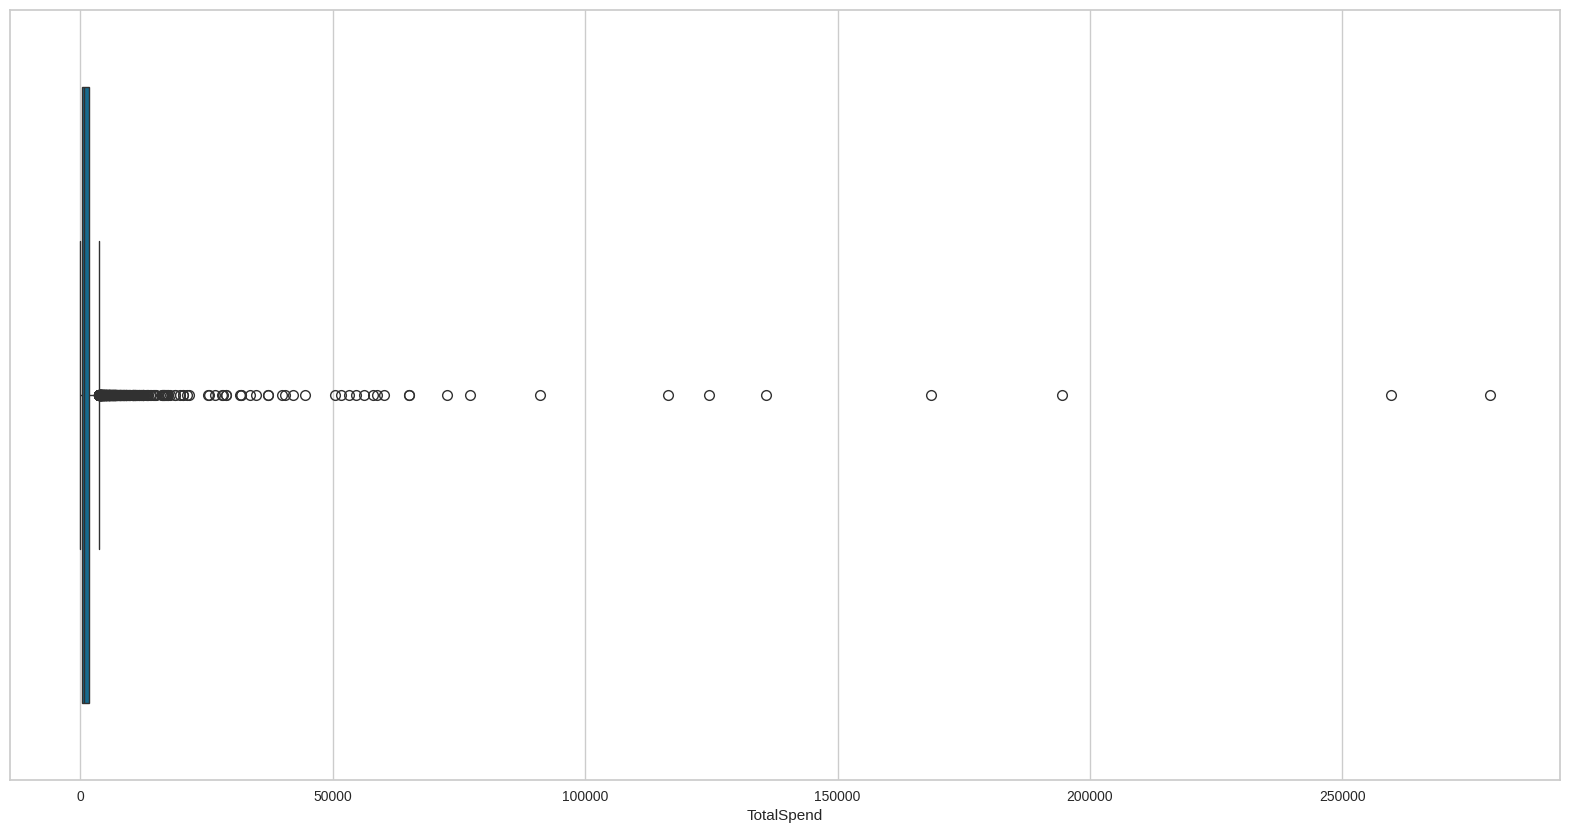

In [155]:
sns.boxplot(x=df_customer['TotalSpend'])

Clients that spend above 50,000 are outliers. Let's analize what is the percentage of outliers given this feature.

In [156]:
outliers = df_customer[df_customer['TotalSpend']>20000].shape[0]
total_customers = df_customer.shape[0]
print(f'Outliers: {outliers/total_customers}')

Outliers: 0.009690816797415782


### Isolation Forest for outlier detection and treatment

Isolation Forest was used for outlier detection because it is well-suited for high-dimensional data and works efficiently by isolating anomalies instead of trying to understand or model normal data. As total spend gave us an idea of outliers proportion, we are going to set contamination in 0.01

In [157]:
IF = IsolationForest(contamination=0.01 ,random_state=0)
# OutlierScores equl to -1 indicate that the datapoint is an outlier or inlier
df_customer['OutlierScore'] = IF.fit_predict(df_customer.iloc[:,1:].to_numpy())
df_customer['OutlierScore'].value_counts()

,count
OutlierScore,
1,4290
-1,44


In [158]:
df_customer_cleaned = df_customer[df_customer['OutlierScore'] == 1].copy()
df_customer_cleaned.drop(columns='OutlierScore', inplace=True)

## CORRELATION

Another important step to consider before performing clustering is checking the degree of correlation between features

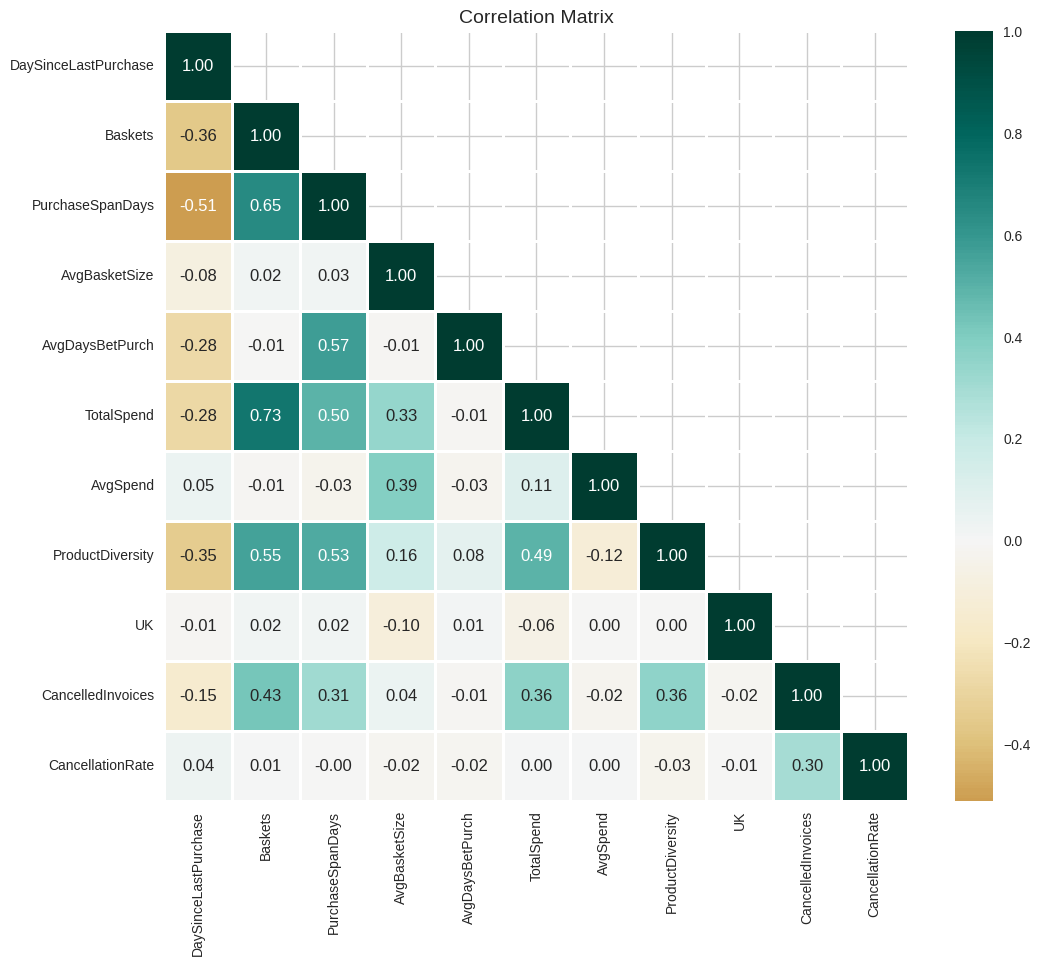

In [159]:
corr = df_customer_cleaned.corr()
# Create a mask to only show the lower triangle of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap='BrBG', annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Although “Baskets” is correlated with both “TotalSpend” and “PurchaseSpanDays,” each variable captures a distinct aspect of customer behavior. “TotalSpend” reflects monetary value, while “Baskets” indicates purchase frequency—both are core dimensions in RFM segmentation and help distinguish between high-frequency low spenders and infrequent high-value customers. “PurchaseSpanDays,” on the other hand, measures customer longevity, enabling analysis of engagement over time. Retaining all three variables provides complementary insights essential for meaningful segmentation and behavior-based profiling.

## DISTRIBUTIONS

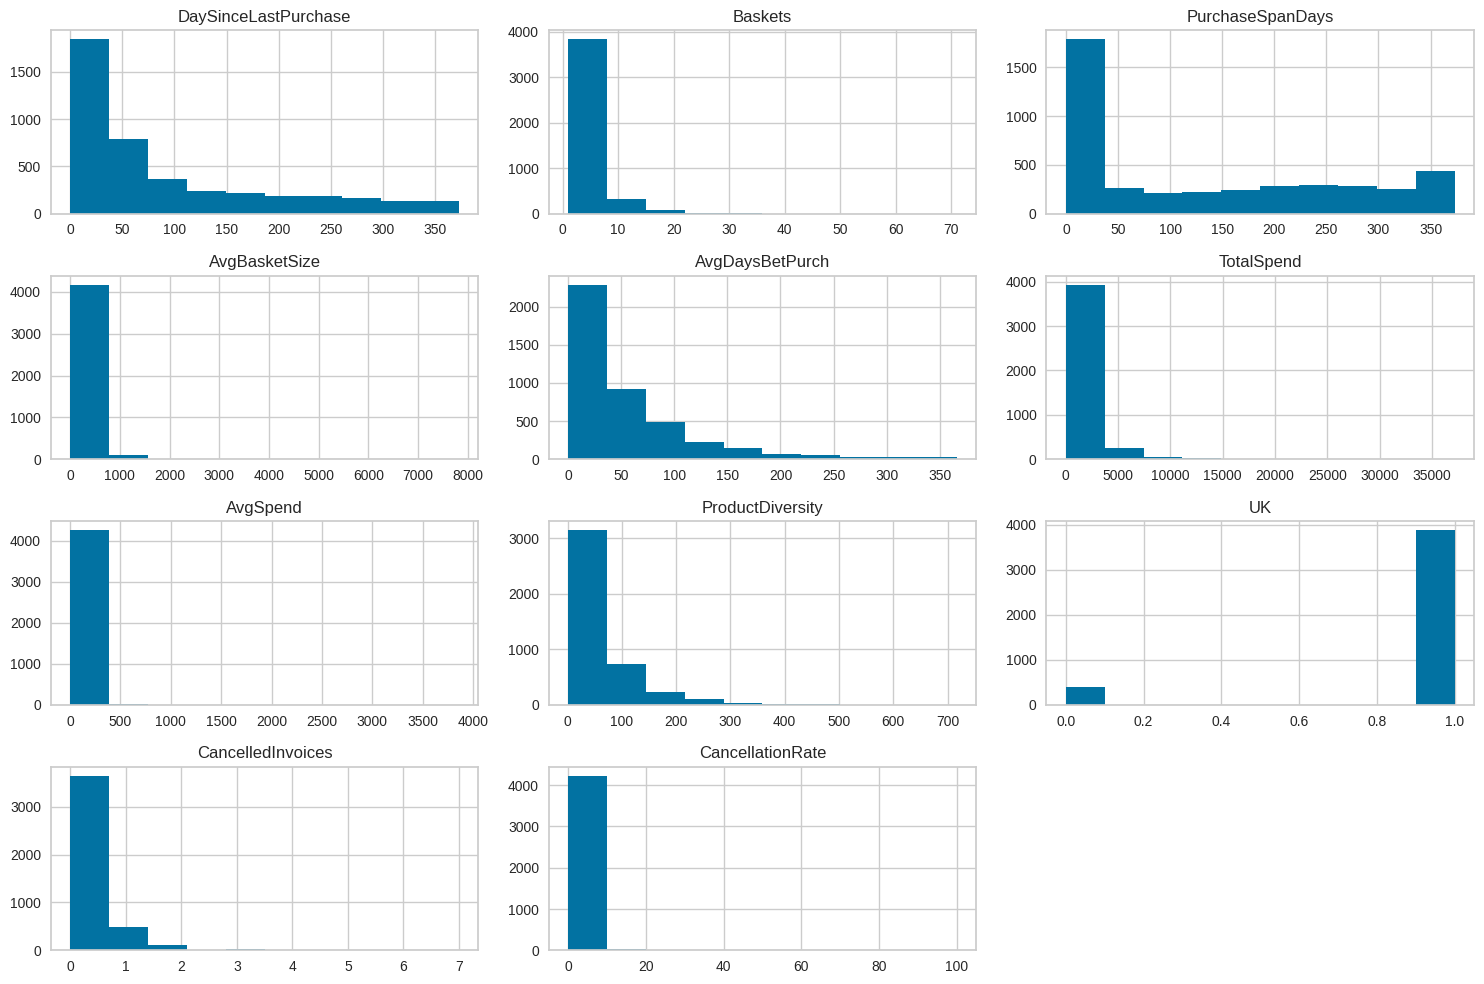

In [160]:
df_customer_cleaned.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

## SKEWNESS CORRECTION

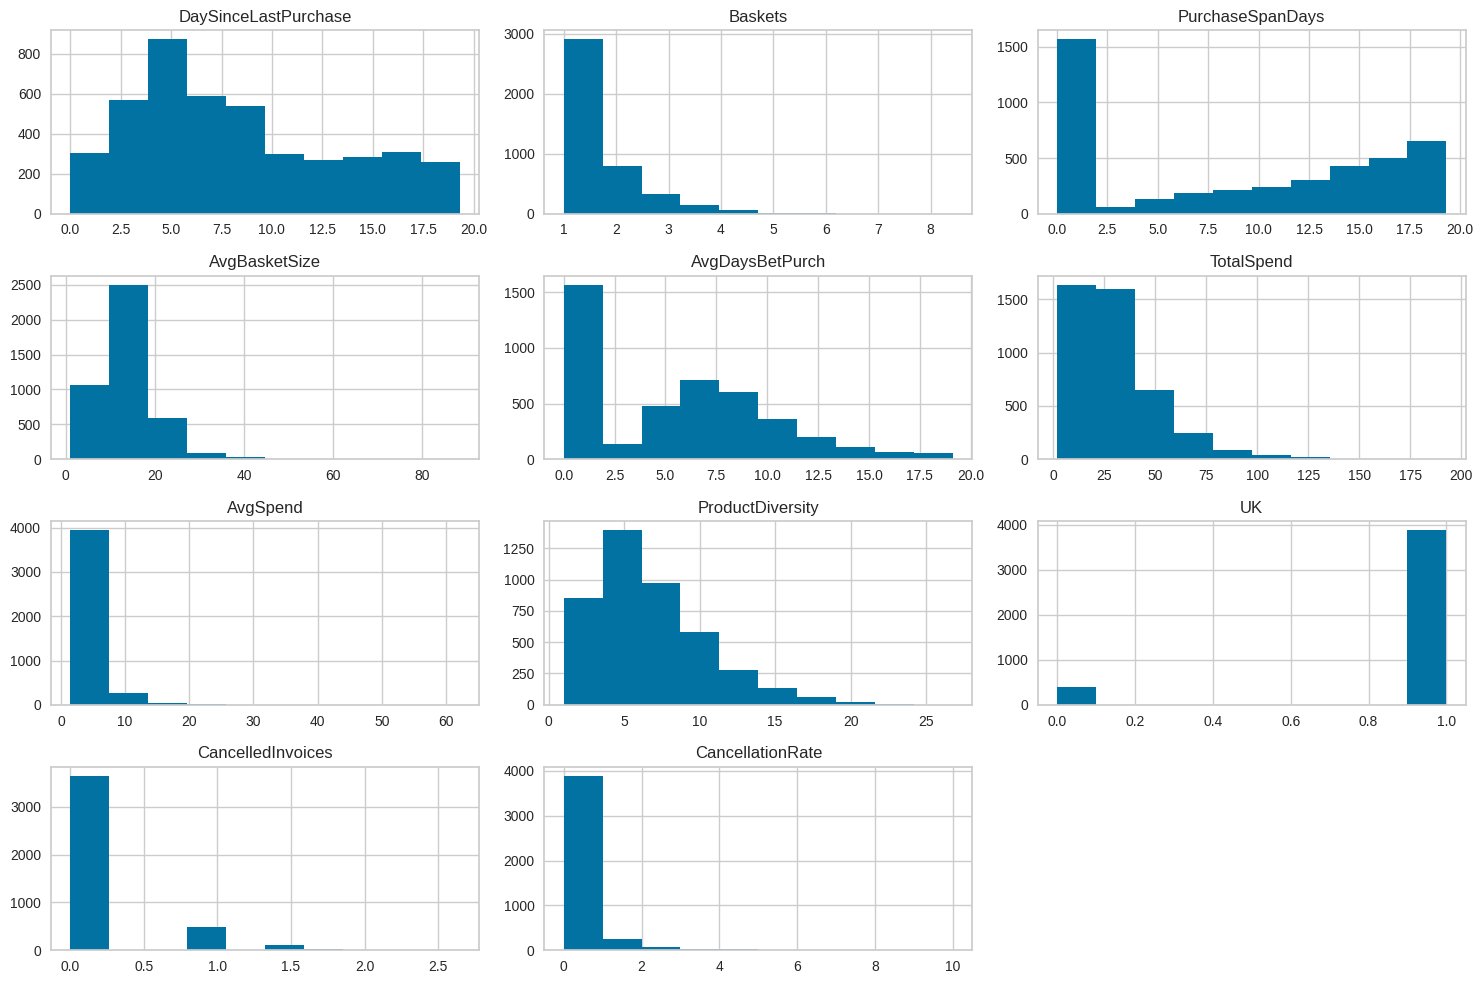

In [161]:
df_sqr = df_customer_cleaned.copy()
df_sqr = np.sqrt(df_sqr)
df_sqr.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

## SCALING

Before applying clustering algorithms, Principal Component Analysis (PCA) will be performed, to reduce dimensionality and visualize the underlying structure of the data. This step helps assess whether the clusters are compact and spherical (favoring K-Means), elliptical (favoring Gaussian Mixture Models), or irregular and density-based (favoring DBSCAN).

As PCA is sensitive to the scale of the input features, all variables will be standardized beforehand to ensure they contribute equally to the principal components. This preprocessing step is essential for obtaining an accurate and unbiased view of the data's geometric structure.

In [162]:
ss = StandardScaler()
excluded_cols = ['UK']
scaled_cols = df_sqr.columns.difference(excluded_cols)
df_scaled = df_sqr.copy()
df_scaled[scaled_cols] = ss.fit_transform(df_scaled[scaled_cols])
df_scaled.head()

,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity,UK,CancelledInvoices,CancellationRate
CustomerID,,,,,,,,,,,
12347,-1.34,1.14,1.41,0.78,0.53,1.63,0.05,0.93,0.00,-0.40,-0.31
12348,0.09,0.36,1.11,1.63,0.93,0.31,0.84,-0.57,0.00,-0.40,-0.31
12349,-0.78,-0.85,-1.16,1.79,-1.10,0.32,-0.07,0.49,0.00,-0.40,-0.31
12350,1.86,-0.85,-1.16,0.03,-1.10,-0.68,-0.14,-0.72,0.00,-0.40,-0.31
12352,-0.44,1.14,1.01,-0.82,0.27,0.28,-0.15,0.23,0.00,1.99,3.69


## DIMENSIONALITY REDUCTION

### PCA

PCA was selected as an initial approach to investigate the shape of the data distribution, particularly to assess whether the data exhibits a spherical structure. By projecting the data onto its principal components, it becomes possible to observe the variance captured along each axis. If the variance is evenly distributed among the components and no single direction dominates, this may suggest a roughly spherical distribution. Additionally, PCA offers a computationally efficient way to explore intrinsic data geometry before applying more complex non-linear methods.

#### Plotting the scree plot to identify the optimal k value

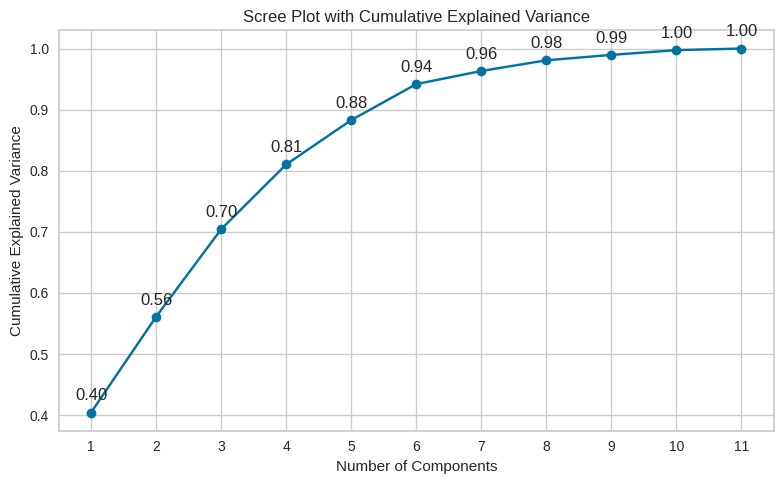

In [163]:
pca = PCA().fit(df_scaled)
exp_var_ratio = pca.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker='o', linestyle='-')

# Añade etiquetas con los valores
for i, val in enumerate(cum_exp_var):
    plt.text(i + 1, val + 0.02, f"{val:.2f}", ha='center')

# Estética del gráfico
plt.title('Scree Plot with Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cum_exp_var) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Since PCA will be used to assess the shape of the data, it is important to retain as much variance as possible to preserve the underlying structure. Therefore, selecting k = 6 is optimal, as it captures approximately 96% of the total variance.

In [164]:
pca_k = PCA(n_components=6)
df_scaled_pca = pca_k.fit_transform(df_scaled)
df_scaled_pca = pd.DataFrame(df_scaled_pca, columns=[f'PC{i+1}' for i in range(df_scaled_pca.shape[1])])
# Adding CustomerID back
df_scaled_pca.index = df_scaled.index

#### Pairplot Analysis

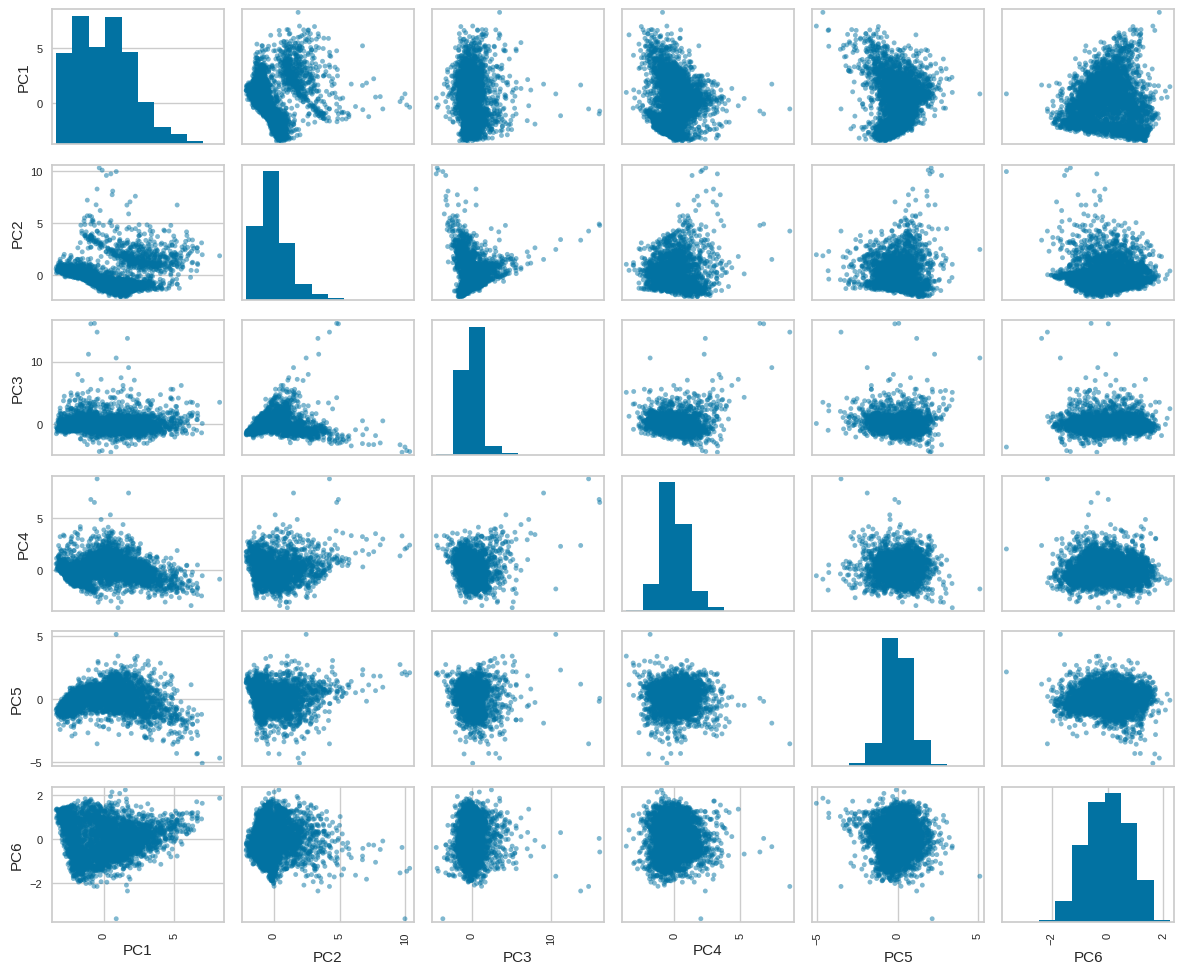

In [165]:
no_components = df_scaled_pca.shape[1]
scatter = pd.plotting.scatter_matrix(df_scaled_pca, figsize=(12, 10))
plt.tight_layout()
plt.show()

The pairplot of the first six principal components shows no clearly separated clusters. The data appears continuous and densely concentrated, with no distinct low-density regions or visible groupings.

Given this structure, K-Means may be suboptimal due to its assumption of spherical clusters. Gaussian Mixture Models offer greater flexibility, as they can accommodate overlapping and elliptical shapes. DBSCAN is also unlikely to be effective, as the relatively uniform density makes it difficult to distinguish meaningful clusters from noise.

To proceed, K-Means and GMM will be applied, and their performance will be evaluated using Silhouette Score and BIC.

## Clustering

### K-Means

#### Elbow Method - Inertia Analysis

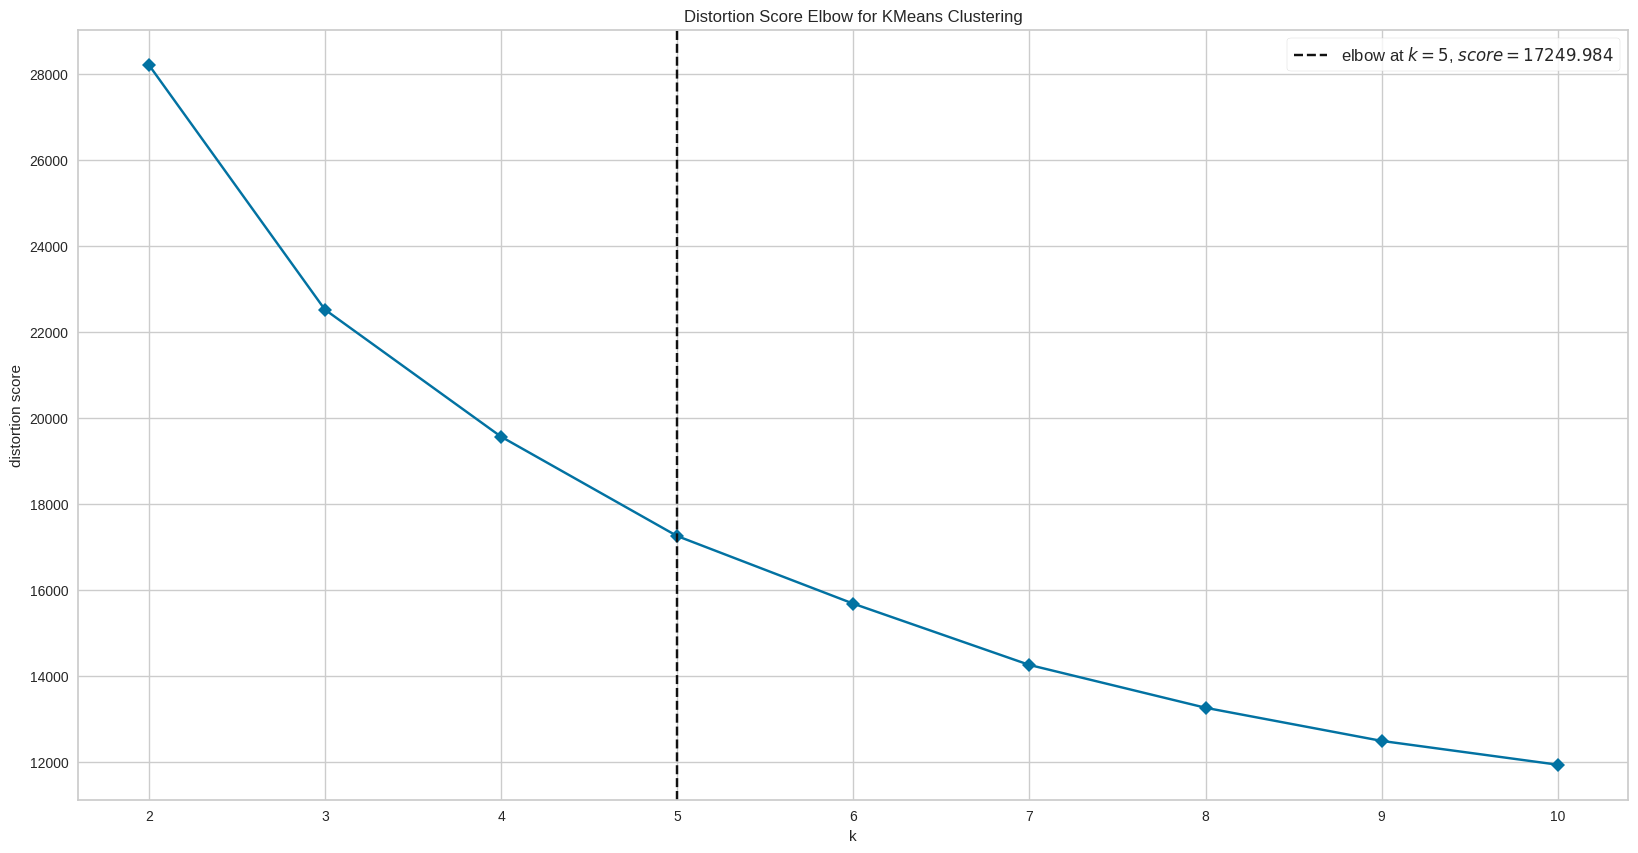

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [166]:
visualizer = KElbowVisualizer(KMeans(random_state=0, n_init=10), k=(2,11), timings=False)
visualizer.fit(df_scaled_pca)
visualizer.show()

The elbow method does not show a clear inflection point, as the distortion score decreases gradually across values of k. This suggests no obvious optimal number of clusters based on inertia alone. To complement this, the Silhouette Score will be applied to further assess clustering structure and determine an appropriate value for k.

#### Silhouette Analysis

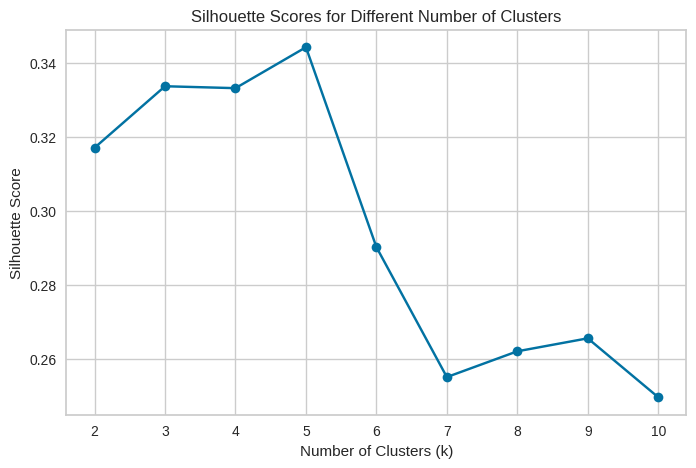

In [167]:
sil_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(df_scaled_pca)
    score = silhouette_score(df_scaled_pca, kmeans.labels_)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o', linestyle='-')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Silhouette Score reaches its maximum at k=5, indicating that this number of clusters provides the best balance between cohesion within clusters and separation between them. This supports the selection of k=5 as a suitable choice for the clustering model.
As the next step, the first five cluster solutions will be analyzed in more detail using Silhouette Plots, which provide insights into the cohesion and separation of individual clusters.

#### Silohuette Plots

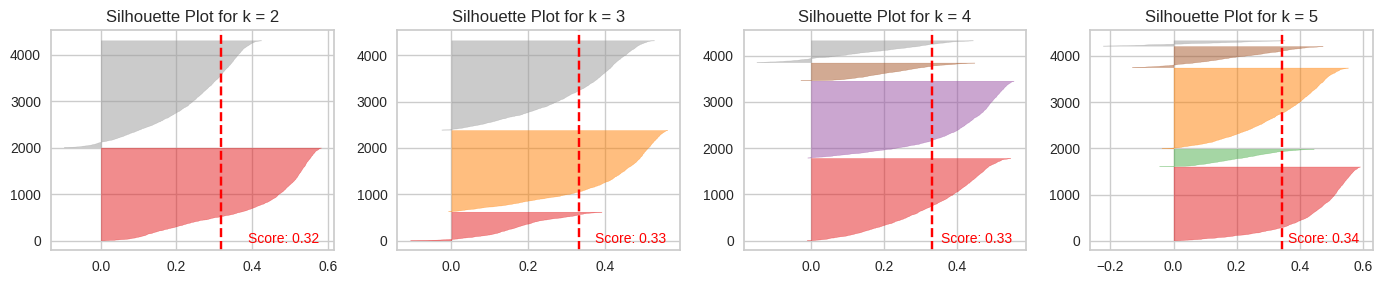

In [168]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes = axes.flatten()

for idx, k in enumerate(range(2,6)):
    ax = axes[idx]
    model = KMeans(n_clusters=k, random_state=0, n_init=10)
    visualizer = SilhouetteVisualizer(model, ax=ax)
    visualizer.fit(df_scaled_pca)
    score = silhouette_score(df_scaled_pca, model.labels_)
    ax.text(0.95, 0.02, f"Score: {score:.2f}", transform=ax.transAxes, ha='right', va='bottom', fontsize=10, color='red')
    ax.set_title(f"Silhouette Plot for k = {k}", fontsize=12)

# Eliminar ejes vacíos si hay
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Although k=5 yields the highest average Silhouette Score (0.34), a closer inspection of the silhouette plots reveals a poorly defined gray cluster with many points exhibiting low or negative scores, indicating weak cohesion and potential misclassification. In contrast, the clusters at k=4 are more balanced, with no group showing clear signs of instability. Despite the slightly lower average score (0.33), the overall cluster structure at k=4 appears more coherent and interpretable. Therefore, k=4 is considered a more practical and robust choice.

#### K-Means Training

In [169]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=200, random_state=0)
kmeans.fit(df_scaled_pca)
cluster_labels = kmeans.labels_
df_customer_cleaned['cluster_kmeans'] = cluster_labels

### Gaussian Mixture Model

#### Finding K with BIC & AIC

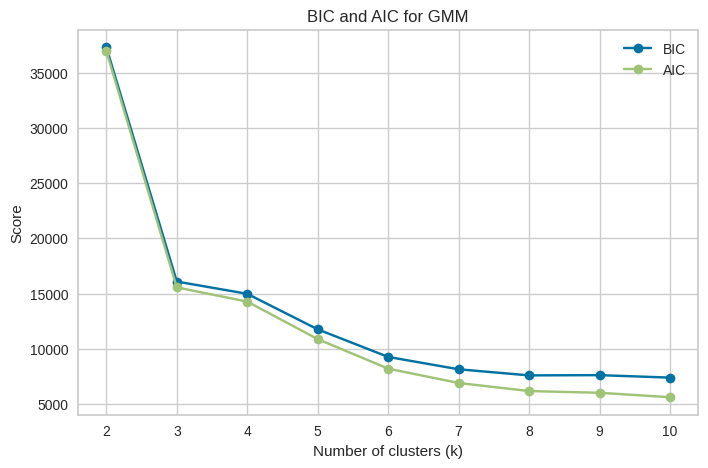

In [170]:
bic_scores = []
aic_scores = []
k_range = range(2, 11)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(df_scaled_pca)
    bic_scores.append(gmm.bic(df_scaled_pca))
    aic_scores.append(gmm.aic(df_scaled_pca))

plt.figure(figsize=(8, 5))
plt.plot(k_range, bic_scores, label='BIC', marker='o')
plt.plot(k_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('BIC and AIC for GMM')
plt.legend()
plt.grid(True)
plt.show()

While both BIC and AIC reach their minimum at k=8, the improvement from k=7 to k=8 is marginal. Choosing k=7 offers a simpler model with comparable performance, reducing the risk of overfitting and enhancing interpretability.

#### GMM Training

In [171]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0)
gmm.fit(df_scaled_pca)
gmm_labels = gmm.predict(df_scaled_pca)
df_customer_cleaned['cluster_gmm'] = gmm_labels

### K-Means vs GMM

In [173]:
kmeans_score = silhouette_score(df_scaled_pca, df_customer_cleaned['cluster_kmeans'])
gmm_score = silhouette_score(df_scaled_pca, df_customer_cleaned['cluster_gmm'])

print(f"Silhouette Score - KMeans: {kmeans_score:.3f}")
print(f"Silhouette Score - GMM: {gmm_score:.3f}")

Silhouette Score - KMeans: 0.333
Silhouette Score - GMM: 0.150


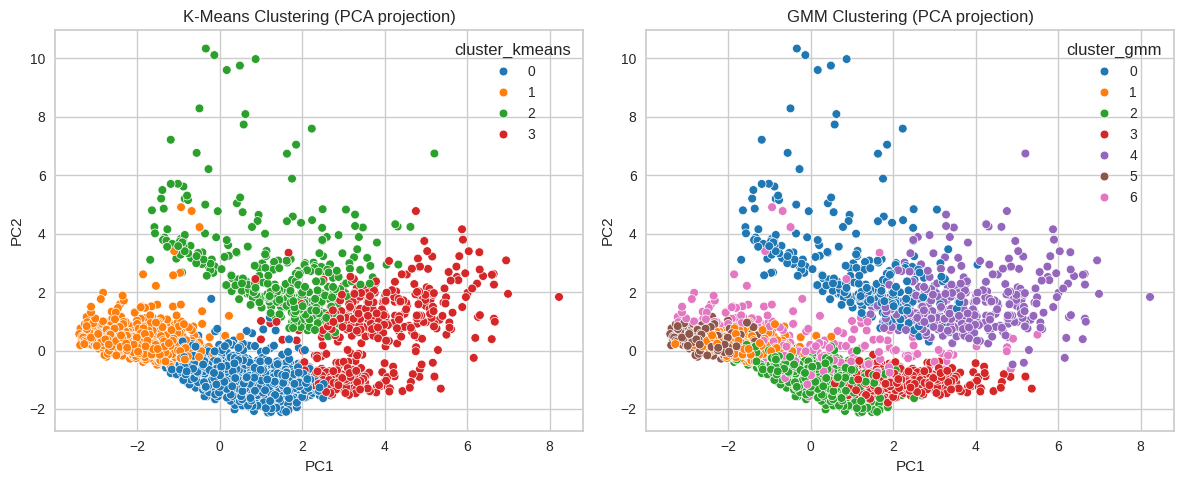

In [175]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_scaled_pca.iloc[:, 0], y=df_scaled_pca.iloc[:, 1],
                hue=df_customer_cleaned['cluster_kmeans'], palette='tab10', s=40)
plt.title("K-Means Clustering (PCA projection)")
plt.xlabel('PC1')
plt.ylabel('PC2')

# Visualización GMM
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_scaled_pca.iloc[:, 0], y=df_scaled_pca.iloc[:, 1],
                hue=df_customer_cleaned['cluster_gmm'], palette='tab10', s=40)
plt.title("GMM Clustering (PCA projection)")
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

Based on the comparison, K-Means outperforms GMM in this case. The Silhouette Score for K-Means is significantly higher (0.378 vs. 0.282), indicating better cohesion within clusters and clearer separation between them. Visually, K-Means produces well-defined and compact clusters in the PCA space, while GMM results in more overlapping and less distinguishable groups. Although GMM offers more flexibility and identifies a greater number of clusters (7), it appears to overfit the data, reducing interpretability without providing meaningful segmentation improvements. Therefore, K-Means is the more suitable model for this dataset.

## Pen Profiles

In [176]:
df_customer_cleaned = df_customer_cleaned.drop(columns='cluster_gmm')

In [179]:

cluster_profiles = df_customer_cleaned.groupby('cluster_kmeans').mean()
cluster_profiles['n_customers'] = df_customer_cleaned['cluster_kmeans'].value_counts().sort_index()
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Cluster Profiles (Mean per feature):")
display(cluster_profiles)

Cluster Profiles (Mean per feature):


,DaySinceLastPurchase,Baskets,PurchaseSpanDays,AvgBasketSize,AvgDaysBetPurch,TotalSpend,AvgSpend,ProductDiversity,UK,CancelledInvoices,CancellationRate,n_customers
cluster_kmeans,,,,,,,,,,,,
0,55.61,3.61,191.56,210.16,97.03,"1,190.45",26.90,60.99,0.92,0.00,0.00,1778
1,155.93,1.12,2.85,207.78,2.47,363.98,38.22,21.98,0.90,0.00,0.00,1660
2,85.32,3.84,168.81,223.19,62.03,"1,395.23",23.49,59.46,0.90,1.25,6.43,381
3,16.76,11.92,306.50,400.34,37.22,"6,088.84",32.35,176.64,0.89,0.83,0.46,471


🟦 Cluster 0 – Steady Essentials

These customers show moderate recency and visit frequency, making purchases steadily over time. Their average basket size and total spend are mid-range, indicating balanced value. They display stable shopping behavior, low cancellation rates, and a preference for essentials. This group represents reliable but not highly engaged buyers.

🟧 Cluster 1 – Ghost Shoppers

Customers in this cluster made a single, brief appearance, with purchases clustered within a few days. They have the lowest total spend, product diversity, and visit frequency. Despite high average spend per visit, their inactivity suggests a lack of long-term engagement. They are likely one-time buyers with minimal impact on overall business value.

🟩 Cluster 2 – Fickle Returners

These are moderately active customers with average purchase frequency and mid-range spend. They stand out for having the highest cancellation rate and number of returns. Their behavior appears inconsistent, possibly indicating dissatisfaction or indecision. They represent a risk group that may require intervention to retain.

🟥 Cluster 3 – Power Loyalists

This group includes the most engaged and valuable customers across all metrics.
They purchase frequently, have high total and average spend, and show broad product interest. Their recent activity and long purchase span reflect strong loyalty and sustained engagement. These are high-priority customers for retention and long-term value generation.

## Exporting Dataset

In [182]:
df_customer_cleaned.to_csv(root_path + 'df_clustering.csv')